### This code plots the 1D and 2D kinematics and differences in kinematics for lep1 and lep2 in $Z \rightarrow \ell\ell$ events. It has a few different switches:

### FIXME:
1. `make_plain_kinem_plots` = A basic kinematic plotter to show the $\eta, p_{T}, \phi, \Delta \mathrm{R}$ for lep1 and lep2, side-by-side.
2. `make_1D_delta_plots` = Differences in kinematics ($\Delta p_{T}, \Delta \eta$, etc.)

#### To Fix:
- If plotting $p_{T}$, make y-label have 'Events/[# GeV]'.
- Consider doing df['branch'].values to increase efficiency.
- Consider not creating so many extra variables to increase efficiency.

In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/Users/Jake/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/d0_Studies/')

# Neat tricks.
from itertools import chain
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from IPython.display import display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Local imports. 
from PyUtils.Utils_Files import makeDirs, make_str_title_friendly
from PyUtils.Utils_Plotting import change_cmap_bkg_to_white, save_plots_to_outpath
from PyUtils.Utils_Physics import theta2pseudorap, pseudorap2theta
from PyUtils.Utils_Collection_Helpers import weave_lists
# from d0_Utils.d0_cls import KinemBinnedEtaPt
from d0_Utils.d0_fns import (add_underoverflow_entries, make_binning_array, calc_dR, calc_dphi, 
                             make_stats_legend_for_1dhist, make_stats_legend_for_2dhist, make_kinem_subplot, get_stats_1Dhist, get_stats_2Dhist)

plt.rcParams.update({'figure.max_open_warning': 10})    # Related to saving memory and opening plots.

# pd.options.display.max_columns = 23
pd.options.display.max_columns = None

plt.style.use('cmsstyle_plot')

In [2]:
%%time
infile_path_MC_2016 = '/Users/Jake/Desktop/MC_2016.h5'
infile_path_MC_2017 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2017.feather'
infile_path_MC_2018 = '/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/NTuples/MC/MC_2018.feather'

# df_MC_2016 = pd.read_feather(infile_path_MC_2016)
# df_MC_2017 = pd.read_feather(infile_path_MC_2017)
# df_MC_2018 = pd.read_feather(infile_path_MC_2018)

df_MC_2016 = pd.read_hdf(infile_path_MC_2016)
# df_MC_2017 = pd.read_hdf(infile_path_MC_2017)
# df_MC_2018 = pd.read_hdf(infile_path_MC_2018)

CPU times: user 229 ms, sys: 6.88 s, total: 7.11 s
Wall time: 18.4 s


In [25]:
class TEST_KinemBinnedEtaPt():
    
    def __init__(self, df_original, n_evts, eta_cut_ls, pT_cut_ls, use_ptotal_instead=False, dR_cut=0.02, verbose=False):
        """
        Pass in a DataFrame (DF) and specify the eta and pT cuts to create a subset of DF.
        
        Parameters
        ----------
        df_original : pandas.DataFrame
            ROOT file converted into a DataFrame. Columns are branches. Rows are events.
        n_evts : int
            Number of events to search over - not guaranteed to find this many events! 
            Use '-1' to loop over all events in the df. 
        eta_cut_ls : list or array-like of floats
            A list of [eta_min, eta_max]. Example: [0.9, 1.8]
        pT_cut_ls : list or array-like of floats
            A list of [pT_min, pT_max]. Example: [5, 20]
        dR_cut : float
            A cut to save events in which muon1 and muon2 both have dR < dR_cut.
            
        FIXME:
            - The methods further down are more developed than the methods closer to __init__(). 
                Therefore, clean up and consolidate the earlier methods. 
            - Also There are two very similar classes: KinemBinnedEtaP and KinemBinnedEtaPt
                Use inheritance!
            - Make method: make_selection(sel)
                Returns only events and all info which pass certain selection criteria (sel).
            - Make plotting methods shorter.
            - In most places, pT could stand for either p or pT (depending on 'use_ptotal_instead').
                Just be careful because not all places are adapted for p!
        """
        if n_evts == -1:
            n_evts = len(df_original)
        df = df_original[:n_evts]    # Original DF. 
        
#         self.binned_df = None    # The DF with the kinematic region cuts applied.
        self.n_evts_asked_for = n_evts
        self.n_evts_found = -999
        
        self.use_ptotal_instead = use_ptotal_instead
        self.p_str = "p" if (self.use_ptotal_instead) else "pT"
        self.p_str_latex = "p" if (self.use_ptotal_instead) else "p_{T}"
        
        self.eta_min   = eta_cut_ls[0]
        self.eta_max   = eta_cut_ls[1]
        self.pT_min    = pT_cut_ls[0] 
        self.pT_max    = pT_cut_ls[1]         
        self.dR_cut    = dR_cut    
        self.massZ_min = 60
        self.massZ_max = 120    
        
        self.apply_pT_eta_cuts(df, verbose)
        
    def apply_pT_eta_cuts(self, df, verbose=False):
        """
        Creates a subset of the original DataFrame.
        The subset contains only the events in which either muon1 passes all eta and pT cuts, or muon2 does, or both muons do. 
        """
        # Cuts:
        eta_min   = self.eta_min  
        eta_max   = self.eta_max  
        pT_min    = self.pT_min   
        pT_max    = self.pT_max   
        dR_cut    = self.dR_cut   
        massZ_min = self.massZ_min
        massZ_max = self.massZ_max

        #----------------#
        #--- Analysis ---#
        #----------------#
        # GEN info. 
        eta1_gen_ser = df['genLep_eta1']
        eta2_gen_ser = df['genLep_eta2']
        phi1_gen_ser = df['genLep_phi1']
        phi2_gen_ser = df['genLep_phi2']
        pT1_gen_ser  = df['genLep_pt1']
        pT2_gen_ser  = df['genLep_pt2']

        # RECO info.
        eta1_rec_ser = df['eta1']
        eta2_rec_ser = df['eta2']
        phi1_rec_ser = df['phi1']
        phi2_rec_ser = df['phi2']
        pT1_rec_ser  = df['pT1']
        pT2_rec_ser  = df['pT2']
        
        # Store other variables.
        df.loc[:,'genLep_theta1'] = theta1_gen_ser = pseudorap2theta(eta1_gen_ser)
        df.loc[:,'genLep_theta2'] = theta2_gen_ser = pseudorap2theta(eta2_gen_ser)
        df.loc[:,'theta1'] = theta1_rec_ser = pseudorap2theta(eta1_rec_ser)
        df.loc[:,'theta2'] = theta2_rec_ser = pseudorap2theta(eta2_rec_ser)
        
        df.loc[:,'genLep_p1'] = pT1_gen_ser / np.sin( theta1_gen_ser )
        df.loc[:,'genLep_p2'] = pT2_gen_ser / np.sin( theta2_gen_ser )
        df.loc[:,'p1'] = pT1_rec_ser / np.sin( theta1_rec_ser )  # Total momentum
        df.loc[:,'p2'] = pT2_rec_ser / np.sin( theta2_rec_ser )  # Total momentum
                        
        df.loc[:,'delta_eta1'] = deta1_ser = eta1_rec_ser - eta1_gen_ser
        df.loc[:,'delta_eta2'] = deta2_ser = eta2_rec_ser - eta2_gen_ser
        df.loc[:,'delta_theta1'] = dtheta1_ser = theta1_rec_ser - theta1_gen_ser
        df.loc[:,'delta_theta2'] = dtheta2_ser = theta2_rec_ser - theta2_gen_ser

        # Remember that delta_phi requires special treatment:
        # -pi < delta_phi < pi
        df.loc[:,'delta_phi1'] = dphi1_ser = calc_dphi(phi1_rec_ser, phi1_gen_ser)
        df.loc[:,'delta_phi2'] = dphi2_ser = calc_dphi(phi2_rec_ser, phi2_gen_ser)

        df.loc[:,'delta_R1'] = dR1_ser = calc_dR(deta1_ser, dphi1_ser)
        df.loc[:,'delta_R2'] = dR2_ser = calc_dR(deta2_ser, dphi2_ser)
        df.loc[:,'delta_Rtheta1'] = dRtheta1_ser = calc_dR(dtheta1_ser, dphi1_ser)
        df.loc[:,'delta_Rtheta2'] = dRtheta2_ser = calc_dR(dtheta2_ser, dphi2_ser)

        # Create masks.
        mask_dR = (dR1_ser < self.dR_cut) & (dR2_ser < self.dR_cut)

        mask_massZ = (massZ_min < df['massZ']) & (df['massZ'] < massZ_max)
        
        if (self.use_ptotal_instead):
            mask_pT1 = (pT_min < df['p1']) & (df['p1'] < pT_max) 
            mask_pT2 = (pT_min < df['p2']) & (df['p2'] < pT_max)
        else:
            mask_pT1 = (pT_min < df['pT1']) & (df['pT1'] < pT_max) 
            mask_pT2 = (pT_min < df['pT2']) & (df['pT2'] < pT_max)
        
        mask_eta1 = (eta_min < abs(df['eta1'])) & (abs(df['eta1']) < eta_max)
        mask_eta2 = (eta_min < abs(df['eta2'])) & (abs(df['eta2']) < eta_max)        

        # Combine masks.
        mask_kinembin_lep1 = mask_eta1 & mask_pT1
        mask_kinembin_lep2 = mask_eta2 & mask_pT2

        all_masks = mask_dR & mask_massZ & (mask_kinembin_lep1 | mask_kinembin_lep2)
        
        # Apply masks and update DataFrame.
        self.binned_df = df[all_masks]
        
        self.cuts =  r"$%d <$ massZ $< %d$" % (self.massZ_min, self.massZ_max)
        self.cuts += r",   $%.2f < \left| \eta \right| < %.2f$" % (self.eta_min, self.eta_max)
        self.cuts += r",   $%d < %s < %d$" % (self.pT_min, self.p_str_latex, self.pT_max)
        self.cuts += r",   $\Delta R < %.3f$" % (self.dR_cut)
        self.n_evts_found = len(self.binned_df)
        
        if (verbose): 
            perc = self.n_evts_found / float(self.n_evts_asked_for) * 100.
            print(f"Events found: {self.n_evts_found} ({perc:.2f}% of total events), using cuts: {self.cuts}")  

In [29]:
class KinemBinnedEtaPt():
    
#------------------#
# Removed copying the original DF. Delete if don't need to copy.
#     def __init__(self, df_original, n_evts, eta_cut_ls, pT_cut_ls, use_ptotal_instead=False, dR_cut=0.02, verbose=False):
#         """
#         Pass in a DataFrame (DF) and specify the eta and pT cuts to create a subset of DF.
        
#         Parameters
#         ----------
#         df_original : pandas.DataFrame
#             ROOT file converted into a DataFrame. Columns are branches. Rows are events.
#         n_evts : int
#             Number of events to search over - not guaranteed to find this many events! 
#             Use '-1' to loop over all events in the df. 
#         eta_cut_ls : list or array-like of floats
#             A list of [eta_min, eta_max]. Example: [0.9, 1.8]
#         pT_cut_ls : list or array-like of floats
#             A list of [pT_min, pT_max]. Example: [5, 20]
#         dR_cut : float
#             A cut to save events in which muon1 and muon2 both have dR < dR_cut.
            
#         FIXME:
#             - The methods further down are more developed than the methods closer to __init__(). 
#                 Therefore, clean up and consolidate the earlier methods. 
#             - Also There are two very similar classes: KinemBinnedEtaP and KinemBinnedEtaPt
#                 Use inheritance!
#             - Make method: make_selection(sel)
#                 Returns only events and all info which pass certain selection criteria (sel).
#             - Make plotting methods shorter.
#             - In most places, pT could stand for either p or pT (depending on 'use_ptotal_instead').
#                 Just be careful because not all places are adapted for p!
#         """
#         if n_evts == -1:
#             n_evts = len(df_original)
#         df = df_original[:n_evts].copy()    # Original DF. 
        
#         self.binned_df = None    # The DF with the kinematic region cuts applied.
#         self.n_evts_asked_for = n_evts
#         self.n_evts_found = -999
        
#         self.use_ptotal_instead = use_ptotal_instead
#         self.p_str = "p" if (self.use_ptotal_instead) else "pT"
#         self.p_str_latex = "p" if (self.use_ptotal_instead) else "p_{T}"
        
#         self.eta_min   = eta_cut_ls[0]
#         self.eta_max   = eta_cut_ls[1]
#         self.pT_min    = pT_cut_ls[0] 
#         self.pT_max    = pT_cut_ls[1]         
#         self.dR_cut    = dR_cut    
#         self.massZ_min = 60
#         self.massZ_max = 120    
        
#         self.apply_pT_eta_cuts(df, verbose)
        
#     def apply_pT_eta_cuts(self, df, verbose=False):
#         """
#         Creates a subset of the original DataFrame.
#         The subset contains only the events in which either muon1 passes all eta and pT cuts, or muon2 does, or both muons do. 
#         """
#         # Cuts:
#         eta_min   = self.eta_min  
#         eta_max   = self.eta_max  
#         pT_min    = self.pT_min   
#         pT_max    = self.pT_max   
#         dR_cut    = self.dR_cut   
#         massZ_min = self.massZ_min
#         massZ_max = self.massZ_max

#         #----------------#
#         #--- Analysis ---#
#         #----------------#
#         # GEN info. 
#         eta1_gen_ser = df['genLep_eta1']
#         eta2_gen_ser = df['genLep_eta2']
#         phi1_gen_ser = df['genLep_phi1']
#         phi2_gen_ser = df['genLep_phi2']
#         pT1_gen_ser  = df['genLep_pt1']
#         pT2_gen_ser  = df['genLep_pt2']

#         # RECO info.
#         eta1_rec_ser = df['eta1']
#         eta2_rec_ser = df['eta2']
#         phi1_rec_ser = df['phi1']
#         phi2_rec_ser = df['phi2']
#         pT1_rec_ser  = df['pT1']
#         pT2_rec_ser  = df['pT2']
        
#         # Store other variables.
#         df['genLep_theta1'] = theta1_gen_ser = pseudorap2theta(eta1_gen_ser)
#         df['genLep_theta2'] = theta2_gen_ser = pseudorap2theta(eta2_gen_ser)
#         df['theta1'] = theta1_rec_ser = pseudorap2theta(eta1_rec_ser)
#         df['theta2'] = theta2_rec_ser = pseudorap2theta(eta2_rec_ser)
        
#         df['genLep_p1'] = pT1_gen_ser / np.sin( theta1_gen_ser )
#         df['genLep_p2'] = pT2_gen_ser / np.sin( theta2_gen_ser )
#         df['p1'] = pT1_rec_ser / np.sin( theta1_rec_ser )  # Total momentum
#         df['p2'] = pT2_rec_ser / np.sin( theta2_rec_ser )  # Total momentum
                        
#         df['delta_eta1'] = deta1_ser = eta1_rec_ser - eta1_gen_ser
#         df['delta_eta2'] = deta2_ser = eta2_rec_ser - eta2_gen_ser
#         df['delta_theta1'] = dtheta1_ser = theta1_rec_ser - theta1_gen_ser
#         df['delta_theta2'] = dtheta2_ser = theta2_rec_ser - theta2_gen_ser

#         # Remember that delta_phi requires special treatment:
#         # -pi < delta_phi < pi
#         df['delta_phi1'] = dphi1_ser = calc_dphi(phi1_rec_ser, phi1_gen_ser)
#         df['delta_phi2'] = dphi2_ser = calc_dphi(phi2_rec_ser, phi2_gen_ser)

#         df['delta_R1'] = dR1_ser = calc_dR(deta1_ser, dphi1_ser)
#         df['delta_R2'] = dR2_ser = calc_dR(deta2_ser, dphi2_ser)
#         df['delta_Rtheta1'] = dRtheta1_ser = calc_dR(dtheta1_ser, dphi1_ser)
#         df['delta_Rtheta2'] = dRtheta2_ser = calc_dR(dtheta2_ser, dphi2_ser)

#         # Create masks.
#         mask_dR = (dR1_ser < self.dR_cut) & (dR2_ser < self.dR_cut)

#         mask_massZ = (massZ_min < df['massZ']) & (df['massZ'] < massZ_max)
        
#         if (self.use_ptotal_instead):
#             mask_pT1 = (pT_min < df['p1']) & (df['p1'] < pT_max) 
#             mask_pT2 = (pT_min < df['p2']) & (df['p2'] < pT_max)
#         else:
#             mask_pT1 = (pT_min < df['pT1']) & (df['pT1'] < pT_max) 
#             mask_pT2 = (pT_min < df['pT2']) & (df['pT2'] < pT_max)
        
#         mask_eta1 = (eta_min < abs(df['eta1'])) & (abs(df['eta1']) < eta_max)
#         mask_eta2 = (eta_min < abs(df['eta2'])) & (abs(df['eta2']) < eta_max)        

#         # Combine masks.
#         mask_kinembin_lep1 = mask_eta1 & mask_pT1
#         mask_kinembin_lep2 = mask_eta2 & mask_pT2

#         all_masks = mask_dR & mask_massZ & (mask_kinembin_lep1 | mask_kinembin_lep2)
        
#         # Apply masks and update DataFrame.
#         self.binned_df = df[all_masks]
        
#         self.cuts =  r"$%d <$ massZ $< %d$" % (self.massZ_min, self.massZ_max)
#         self.cuts += r",   $%.2f < \left| \eta \right| < %.2f$" % (self.eta_min, self.eta_max)
#         self.cuts += r",   $%d < %s < %d$" % (self.pT_min, self.p_str_latex, self.pT_max)
#         self.cuts += r",   $\Delta R < %.3f$" % (self.dR_cut)
#         self.n_evts_found = len(self.binned_df)
        
#         if (verbose): 
#             perc = self.n_evts_found / float(self.n_evts_asked_for) * 100.
#             print(f"Events found: {self.n_evts_found} ({perc:.2f}% of total events), using cuts: {self.cuts}")  

#------------------#

    def __init__(self, df_original, n_evts, eta_cut_ls, pT_cut_ls, use_ptotal_instead=False, dR_cut=0.02, verbose=False):
        """
        Pass in a DataFrame (DF) and specify the eta and pT cuts to create a subset of DF.
        
        Parameters
        ----------
        df_original : pandas.DataFrame
            ROOT file converted into a DataFrame. Columns are branches. Rows are events.
        n_evts : int
            Number of events to search over - not guaranteed to find this many events! 
            Use '-1' to loop over all events in the df. 
        eta_cut_ls : list or array-like of floats
            A list of [eta_min, eta_max]. Example: [0.9, 1.8]
        pT_cut_ls : list or array-like of floats
            A list of [pT_min, pT_max]. Example: [5, 20]
        dR_cut : float
            A cut to save events in which muon1 and muon2 both have dR < dR_cut.
            
        FIXME:
            - The methods further down are more developed than the methods closer to __init__(). 
                Therefore, clean up and consolidate the earlier methods. 
            - Also There are two very similar classes: KinemBinnedEtaP and KinemBinnedEtaPt
                Use inheritance!
            - Make method: make_selection(sel)
                Returns only events and all info which pass certain selection criteria (sel).
            - Make plotting methods shorter.
            - In most places, pT could stand for either p or pT (depending on 'use_ptotal_instead').
                Just be careful because not all places are adapted for p!
        """
        if n_evts == -1:
            n_evts = len(df_original)
        df = df_original[:n_evts]    # Original DF. 
        
#         self.binned_df = None    # The DF with the kinematic region cuts applied.
        self.n_evts_asked_for = n_evts
        self.n_evts_found = -999
        
        self.use_ptotal_instead = use_ptotal_instead
        self.p_str = "p" if (self.use_ptotal_instead) else "pT"
        self.p_str_latex = "p" if (self.use_ptotal_instead) else "p_{T}"
        
        self.eta_min   = eta_cut_ls[0]
        self.eta_max   = eta_cut_ls[1]
        self.pT_min    = pT_cut_ls[0] 
        self.pT_max    = pT_cut_ls[1]         
        self.dR_cut    = dR_cut    
        self.massZ_min = 60
        self.massZ_max = 120    
        
        self.apply_pT_eta_cuts(df, verbose)
        
    def apply_pT_eta_cuts(self, df, verbose=False):
        """
        Creates a subset of the original DataFrame.
        The subset contains only the events in which either muon1 passes all eta and pT cuts, or muon2 does, or both muons do. 
        """
        # Cuts:
        eta_min   = self.eta_min  
        eta_max   = self.eta_max  
        pT_min    = self.pT_min   
        pT_max    = self.pT_max   
        dR_cut    = self.dR_cut   
        massZ_min = self.massZ_min
        massZ_max = self.massZ_max

        #----------------#
        #--- Analysis ---#
        #----------------#
        # GEN info. 
        eta1_gen_ser = df['genLep_eta1']
        eta2_gen_ser = df['genLep_eta2']
        phi1_gen_ser = df['genLep_phi1']
        phi2_gen_ser = df['genLep_phi2']
        pT1_gen_ser  = df['genLep_pt1']
        pT2_gen_ser  = df['genLep_pt2']

        # RECO info.
        eta1_rec_ser = df['eta1']
        eta2_rec_ser = df['eta2']
        phi1_rec_ser = df['phi1']
        phi2_rec_ser = df['phi2']
        pT1_rec_ser  = df['pT1']
        pT2_rec_ser  = df['pT2']
        
        # Store other variables.
        df.loc[:,'genLep_theta1'] = theta1_gen_ser = pseudorap2theta(eta1_gen_ser)
        df.loc[:,'genLep_theta2'] = theta2_gen_ser = pseudorap2theta(eta2_gen_ser)
        df.loc[:,'theta1'] = theta1_rec_ser = pseudorap2theta(eta1_rec_ser)
        df.loc[:,'theta2'] = theta2_rec_ser = pseudorap2theta(eta2_rec_ser)
        
        df.loc[:,'genLep_p1'] = pT1_gen_ser / np.sin( theta1_gen_ser )
        df.loc[:,'genLep_p2'] = pT2_gen_ser / np.sin( theta2_gen_ser )
        df.loc[:,'p1'] = pT1_rec_ser / np.sin( theta1_rec_ser )  # Total momentum
        df.loc[:,'p2'] = pT2_rec_ser / np.sin( theta2_rec_ser )  # Total momentum
                        
        df.loc[:,'delta_eta1'] = deta1_ser = eta1_rec_ser - eta1_gen_ser
        df.loc[:,'delta_eta2'] = deta2_ser = eta2_rec_ser - eta2_gen_ser
        df.loc[:,'delta_theta1'] = dtheta1_ser = theta1_rec_ser - theta1_gen_ser
        df.loc[:,'delta_theta2'] = dtheta2_ser = theta2_rec_ser - theta2_gen_ser

        # Remember that delta_phi requires special treatment:
        # -pi < delta_phi < pi
        df.loc[:,'delta_phi1'] = dphi1_ser = calc_dphi(phi1_rec_ser, phi1_gen_ser)
        df.loc[:,'delta_phi2'] = dphi2_ser = calc_dphi(phi2_rec_ser, phi2_gen_ser)

        df.loc[:,'delta_R1'] = dR1_ser = calc_dR(deta1_ser, dphi1_ser)
        df.loc[:,'delta_R2'] = dR2_ser = calc_dR(deta2_ser, dphi2_ser)
        df.loc[:,'delta_Rtheta1'] = dRtheta1_ser = calc_dR(dtheta1_ser, dphi1_ser)
        df.loc[:,'delta_Rtheta2'] = dRtheta2_ser = calc_dR(dtheta2_ser, dphi2_ser)

        # Create masks.
        mask_dR = (dR1_ser < self.dR_cut) & (dR2_ser < self.dR_cut)

        mask_massZ = (massZ_min < df['massZ']) & (df['massZ'] < massZ_max)
        
        if (self.use_ptotal_instead):
            mask_pT1 = (pT_min < df['p1']) & (df['p1'] < pT_max) 
            mask_pT2 = (pT_min < df['p2']) & (df['p2'] < pT_max)
        else:
            mask_pT1 = (pT_min < df['pT1']) & (df['pT1'] < pT_max) 
            mask_pT2 = (pT_min < df['pT2']) & (df['pT2'] < pT_max)
        
        mask_eta1 = (eta_min < abs(df['eta1'])) & (abs(df['eta1']) < eta_max)
        mask_eta2 = (eta_min < abs(df['eta2'])) & (abs(df['eta2']) < eta_max)        

        # Combine masks.
        mask_kinembin_lep1 = mask_eta1 & mask_pT1
        mask_kinembin_lep2 = mask_eta2 & mask_pT2

        all_masks = mask_dR & mask_massZ & (mask_kinembin_lep1 | mask_kinembin_lep2)
        
        # Apply masks and update DataFrame.
        self.binned_df = df[all_masks]
        
        self.cuts =  r"$%d <$ massZ $< %d$" % (self.massZ_min, self.massZ_max)
        self.cuts += r",   $%.2f < \left| \eta \right| < %.2f$" % (self.eta_min, self.eta_max)
        self.cuts += r",   $%d < %s < %d$" % (self.pT_min, self.p_str_latex, self.pT_max)
        self.cuts += r",   $\Delta R < %.3f$" % (self.dR_cut)
        self.n_evts_found = len(self.binned_df)
        
        if (verbose): 
            perc = self.n_evts_found / float(self.n_evts_asked_for) * 100.
            print(f"Events found: {self.n_evts_found} ({perc:.2f}% of total events), using cuts: {self.cuts}")  
    
    def make2Dplot_pT_vs_eta(self, eta_2D_limits=[-2.5, 2.5, 0.1], pT_2D_limits=[0, 100, 1], save_plot=False, save_as_png=False, verbose=False, outpath=""):
        """
        FIXME: Still need to update this method to work with `use_ptotal_instead` bool. 
        
        Make a 2D plot of pT vs. eta. 
        User can specify the binning along either axis. 
        
        Parameters
        ----------
        eta_2D_limits : list or array-like of floats
            The limits on the horizontal axis.
            [eta_min, eta_max, bin_width]. Example: [-2.5, 2.5, 0.1]
        pT_2D_limits : list or array-like of floats
            The limits on the vertical axis.
            [pT_min, pT_max, bin_width]. Example: [0, 100, 1]
        save_plot : bool
            If True, save the plot as a pdf and png.
        outpath : str
            Path to save plot.
        """
        eta_2D_bins, eta_2D_bin_width = make_binning_array(eta_2D_limits)
        pT_2D_bins, pT_2D_bin_width = make_binning_array(pT_2D_limits)        
        
        fontsize_xlabel = 15
        fontsize_ylabel = 15
        f = plt.figure(figsize=(10,8))

        ax = f.add_subplot()
        ax.set_xlabel(r'$\eta$,  (bin width = %.1f)'            % eta_2D_bin_width, fontsize=fontsize_xlabel)
        ax.set_ylabel(r'p$_{T}$ [GeV],  (bin width = %.1f GeV)' % pT_2D_bin_width,  fontsize=fontsize_ylabel)

        title  = r'$\mu_{1}^{RECO}$ or $\mu_{2}^{RECO}$, in 2016 DY MC' + "\n" + r"cuts: "
        title += r"$%d <$ massZ $< %d$" % (self.massZ_min, self.massZ_max)
        title += r",   $%.1f < \left| \eta \right| < %.1f$" % (self.eta_min, self.eta_max)
        title += r",   $%d < p_{T} < %d$" % (self.pT_min, self.pT_max)
        title += r",   $\Delta R < %.3f$" % (self.dR_cut)
        ax.set_title(title)

        plt.style.use('cmsstyle_plot')

        x_vals = np.append(self.binned_df['eta1'].values, self.binned_df['eta2'].values)
        y_vals = np.append(self.binned_df['pT1'].values,  self.binned_df['pT2'].values)

        newcmp = change_cmap_bkg_to_white('plasma')
        bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x_vals, y_vals, bins=[eta_2D_bins, pT_2D_bins], cmap=newcmp)
        plt.colorbar(im, ax=ax)
        
        file_name  = "pT_vs_eta_2Dplot"
        file_name += "__%.1f_eta_%.1f" % (self.eta_min, self.eta_max)
        file_name += "__%d_pT_%d" % (self.pT_min, self.pT_max)
        
        save_plots_to_outpath(save_plot, outpath, file_name, save_as_png, verbose)
        
    def make2Dplot_dphivsdeta(self, x_2D_limits=[0, 1, 0.1], y_2D_limits=[0, 2, 0.2], save_plot=False, save_as_png=False, verbose=False, outpath=""):
        """
        FIXME: 
            - Still need to update this method to work with `use_ptotal_instead` bool. 
            - Update this method to look like: 
        
        Make a 2D plot of pT vs. eta. 
        ser can specify the binning along either axis. 
        
        Parameters
        ----------
        eta_2D_limits : list or array-like of floats
            The limits on the horizontal axis.
            [eta_min, eta_max, bin_width]. Example: [-2.5, 2.5, 0.1]
        pT_2D_limits : list or array-like of floats
            The limits on the vertical axis.
            [pT_min, pT_max, bin_width]. Example: [0, 100, 1]
        save_plot : bool
            If True, save the plot as a pdf and png.
        outpath : str
            Path to save plot.
            
        FIXME:
        - Maybe generalize this into a method to make any 2D plot.
        """
        
        x_2D_bins, x_2D_bin_width = make_binning_array(x_2D_limits)
        y_2D_bins, y_2D_bin_width = make_binning_array(y_2D_limits)        
        
        f = plt.figure(figsize=(10,8))

        ax = f.add_subplot()
        ax.set_xlabel(r'$\Delta \eta = \eta^{RECO} - \eta^{GEN}$,  (bin width = %.1E)' % x_2D_bin_width, fontsize=15)
        ax.set_ylabel(r'$\Delta \phi = \phi^{RECO} - \phi^{GEN}$,  (bin width = %.1E)' % y_2D_bin_width, fontsize=15)

        title  = r"$\Delta \phi$ vs. $\Delta \eta$, for gen-matched muons in 2016 DY MC, with cuts: " + "\n"
        title += r"$%d <$ massZ $< %d$" % (self.massZ_min, self.massZ_max)
        title += r",   $%.1f < \left| \eta \right| < %.1f$" % (self.eta_min, self.eta_max)
        title += r",   $%d < p_{T} < %d$" % (self.pT_min, self.pT_max)
        title += r",   $\Delta R < %.3f$" % (self.dR_cut)
        ax.set_title(title)

        plt.style.use('cmsstyle_plot')

        x_vals = np.append(self.binned_df['delta_eta1'].values, self.binned_df['delta_eta2'].values)
        y_vals = np.append(self.binned_df['delta_phi1'].values, self.binned_df['delta_phi2'].values)

        newcmp = change_cmap_bkg_to_white('plasma')
        bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x_vals, y_vals, bins=[x_2D_bins, y_2D_bins], cmap=newcmp)
        plt.colorbar(im, ax=ax)
        
        file_name  = "2Dplot_dphi_vs_deta"
        file_name += "__%.1f_eta_%.1f" % (self.eta_min, self.eta_max)
        file_name += "__%d_pT_%d" % (self.pT_min, self.pT_max)
        
        save_plots_to_outpath(save_plot, outpath, file_name, save_as_png, verbose)
                  


    def make2Dplot_dPhi_vs_dEtaANDdTheta(self, 
                                       run_over_only_n_evts=-1, 
                                       x1_bounds=[0, 1, 0.1], 
                                       x2_bounds=[0, 2, 0.2], 
                                       y_bounds=[0, 2, 0.2], 
                                       exclusive=True,
                                       save_plot=False, save_as_png=False, verbose=False, outpath=""):
        """
        Make side-by-side 2D plots of:
            (1) dphi vs. deta  
            (2) dphi vs. dtheta
        User can specify the binning along either axis. 
        This method plots only the muons which pass the selection - not all events in which 
        at least 1 muon pass kinematic bin criteria.
        
        Parameters
        ----------
        eta_2D_limits : list or array-like of floats
            The limits on the horizontal axis.
            [eta_min, eta_max, bin_width]. Example: [-2.5, 2.5, 0.1]
        pT_2D_limits : list or array-like of floats
            The limits on the vertical axis.
            [pT_min, pT_max, bin_width]. Example: [0, 100, 1]
        save_plot : bool
            If True, save the plot as a pdf and png.
        outpath : str
            Path to save plot.
            
        FIXME:
        - Maybe generalize this into a method to make any 2D plot.
        """           
        if run_over_only_n_evts == -1:
            run_over_only_n_evts = self.n_evts_found
        
        x1_2D_bins, x1_2D_bin_width = make_binning_array(x1_bounds)
        x2_2D_bins, x2_2D_bin_width = make_binning_array(x2_bounds)
        y_2D_bins, y_2D_bin_width = make_binning_array(y_bounds)        

        n = run_over_only_n_evts
        
        
        x1_vals, x2_vals_inv, y_vals = self.get_muon_dEta_dTheta_dPhi(run_over_only_n_evts=n, exclusive=exclusive)    
        
        #--- Make plots ---#
        f = plt.figure(figsize=(28, 10))

        # Plot 1: dphi vs. deta
        ax = f.add_subplot(121)
        ax.set_xlabel(r'$\Delta \eta = \eta^{RECO} - \eta^{GEN}$,  (bin width = %.1E)' % x1_2D_bin_width, fontsize=15)
        ax.set_ylabel(r'$\Delta \phi = \phi^{RECO} - \phi^{GEN}$,  (bin width = %.1E)' % y_2D_bin_width, fontsize=15)
        
        title  = r"$\Delta \phi$ vs. $\Delta \eta$, for gen-matched muons in 2016 DY MC"
        title += "\n" + "Only includes muons which pass:" + "\n"
        
        cuts  = r"$%d <$ massZ $< %d$" % (self.massZ_min, self.massZ_max)
        cuts += r",   $%.2f < \left| \eta \right| < %.2f$" % (self.eta_min, self.eta_max)
        cuts += r",   $%d < %s < %d$" % (self.pT_min, self.p_str_latex, self.pT_max)
        cuts += r",   $\Delta R < %.3f$" % (self.dR_cut)
        ax.set_title(title + cuts)
    
        plt.style.use('cmsstyle_plot')

        # Stats: 
        stat_text_x = 0.8
        stat_text_y = 0.9
        
        stats_ls1 = get_stats_2Dhist(x1_vals, y_vals)
        leg_label1 = make_stats_legend_for_2dhist(stats_ls1)
        ax.text(stat_text_x, stat_text_y, leg_label1, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
        newcmp = change_cmap_bkg_to_white('rainbow')
        bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x1_vals, y_vals, bins=[x1_2D_bins, y_2D_bins], cmap=newcmp)
        plt.colorbar(im, ax=ax)
        
        # Plot 2: dphi vs. dtheta
        ax = f.add_subplot(122)
        ax.set_xlabel(r'$- \Delta \theta = - (\theta^{RECO} - \theta^{GEN})$,  (bin width = %.1E)' % x2_2D_bin_width, fontsize=15)
        ax.set_ylabel(r'$\Delta \phi = \phi^{RECO} - \phi^{GEN}$,  (bin width = %.1E)' % y_2D_bin_width, fontsize=15)
        title  = r"$\Delta \phi$ vs. $- \Delta \theta$, for gen-matched muons in 2016 DY MC"
        title += "\n" + "Only includes muons which pass:" + "\n"
        ax.set_title(title + cuts)        
        
        plt.style.use('cmsstyle_plot')
            
        # Stats: 
        stats_ls2 = get_stats_2Dhist(x2_vals_inv, y_vals)
        leg_label2 = make_stats_legend_for_2dhist(stats_ls2)
        ax.text(stat_text_x, stat_text_y, leg_label2, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
        newcmp = change_cmap_bkg_to_white('rainbow')
        bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x2_vals_inv, y_vals, bins=[x2_2D_bins, y_2D_bins], cmap=newcmp)
        
        plt.colorbar(im, ax=ax)        
        
        # Save plots, if you want. 
        file_name  = "2Dplot_dphi_vs_detaANDdtheta"
        file_name += "__%.2f_eta_%.2f" % (self.eta_min, self.eta_max)
        file_name += "__%d_%s_%d" % (self.pT_min, self.p_str, self.pT_max)
        
        save_plots_to_outpath(save_plot, outpath, file_name, save_as_png, verbose)
        
        # If exclusive cuts: n_muon_entries should be >= number of events (self.n_evts_found).
        # If inclusive cuts: n_muon_entries should be TWICE the number of events (self.n_evts_found). CHECK IT!
        self.n_muon_entries = len(x1_vals)  

    def get_muon_dEta_dTheta_dPhi(self, run_over_only_n_evts=-1, exclusive=True):
        """
        Return the muon data which pass selection.

        Wait... I only select the first n muons which pass selection. 
        I first grab all muon1 and then start grabbing muon2...

        If muon1 always has a higher pT than muon2, then this could introduce some bias. 
        THIS IS THE CASE: muon1 has higher pT 99.5% of the time. 
        
        [X] Solution: weave mu1 and mu2 vals together. 
        """
        #--- Masks ---# 
        df = self.binned_df
        
        if (self.use_ptotal_instead):
            mask_pT1 = (self.pT_min < df['p1']) & (df['p1'] < self.pT_max) 
            mask_pT2 = (self.pT_min < df['p2']) & (df['p2'] < self.pT_max)
        else:
            mask_pT1 = (self.pT_min < df['pT1']) & (df['pT1'] < self.pT_max) 
            mask_pT2 = (self.pT_min < df['pT2']) & (df['pT2'] < self.pT_max)
            
        mask_eta1 = (self.eta_min < abs(df['eta1'])) & (abs(df['eta1']) < self.eta_max)
        mask_eta2 = (self.eta_min < abs(df['eta2'])) & (abs(df['eta2']) < self.eta_max)        

        # Combine masks.
        mask_kinembin_lep1 = mask_eta1 & mask_pT1
        mask_kinembin_lep2 = mask_eta2 & mask_pT2
        
        #--- Get data ---#
        if (exclusive):   
            # Keep only the muons which pass the kinem bin selection. 
            deta_vals_muon1 = df['delta_eta1'][mask_kinembin_lep1].values  # Muon 1 passes kinem bin selection.
            deta_vals_muon2 = df['delta_eta2'][mask_kinembin_lep2].values  # Muon 2 passes kinem bin selection.
            
            dtheta_vals_muon1 = df['delta_theta1'][mask_kinembin_lep1].values  # Muon 1 passes kinem bin selection.
            dtheta_vals_muon2 = df['delta_theta2'][mask_kinembin_lep2].values  # Muon 2 passes kinem bin selection.
            
            y_vals_muon1 = df['delta_phi1'][mask_kinembin_lep1].values
            y_vals_muon2 = df['delta_phi2'][mask_kinembin_lep2].values
            
            if run_over_only_n_evts == -1:
                # Running over all events. No need to slice.
                x1_vals = np.append(deta_vals_muon1, deta_vals_muon2)
                x2_vals = np.append(dtheta_vals_muon1, dtheta_vals_muon2)
                y_vals = np.append(y_vals_muon1, y_vals_muon2)
            else:
                n = run_over_only_n_evts
                # Weave muon1 and muon2 values together in systematic way.
                # Otherwise muon1 values would mostly be selected when doing a slice, like [:n].
                x1_weave_ls = weave_lists(deta_vals_muon1, deta_vals_muon2)
                x1_vals = np.array(x1_weave_ls)[:n]

                x2_weave_ls = weave_lists(dtheta_vals_muon1, dtheta_vals_muon2)
                x2_vals = np.array(x2_weave_ls)[:n]
                x2_vals = x2_vals * -1

                y_weave_ls = weave_lists(y_vals_muon1, y_vals_muon2)
                y_vals = np.array(y_weave_ls)[:n]
            
        else:
            #--------# DEPRECATED FOR NOW.
            # Keep both muons from each event in which AT LEAST ONE muon passed the kinem bin selection. 
            raise RuntimeError("Stopping now. This section hasn't been fully developed.\nSet exclusive=True.")
            
            x1_vals = np.append(self.binned_df['delta_eta1'][:n].values, self.binned_df['delta_eta2'][:n].values)
            y_vals = np.append(self.binned_df['delta_phi1'][:n].values, self.binned_df['delta_phi2'][:n].values)

            x2_vals = np.append(self.binned_df['delta_theta1'][:n].values, self.binned_df['delta_theta2'][:n].values)
            x2_vals = x2_vals * -1
            y_vals = np.append(self.binned_df['delta_phi1'][:n].values, self.binned_df['delta_phi2'][:n].values)
            #--------#
            
        self.x1_vals = x1_vals
        self.x2_vals = x2_vals
        self.y_vals = y_vals
        
        return x1_vals, x2_vals, y_vals 
        
    def plot_d0_dist(self):
        """
        Plot the d0_BS  d0BS1 d0BS2 d0PV1 d0PV2
        """
        pass
                  
    def plot_kinematics(self):
        """
        Plot the dR, dphi, deta, dtheta distributions within this kinematic region
        """
        pass
    
    def count_in_pT_eta_region_exclusive(self):
        """
        Return the number of muons in the DF subset which pass the eta and pT cuts. 
        'Exclusive' because only those muons which pass such cuts are counted 
        (as opposed to counting both muons from event just because one pass the cuts).
        """
        pass
#         return n_passed = 

# $\Delta \phi$ vs. $\Delta \eta$ AND $\Delta \theta$ 2D plots.

#### Loop over $\Delta \phi$ vs. $(\Delta \eta, \Delta \theta)$ plots --- or ---make a PDF

In [17]:
%%time
# %%capture

n_evts_scan = 10000000
n_evts_keep = 5000

# eta_bin_edges = [0.00, 0.30] # barrel
# eta_bin_edges = [0.80, 1.10]  # overlap
eta_bin_edges = [2.10, 2.40]  # endcap

# eta_bin_edges = [0.00, 0.10, 0.20, 0.30]    # barrel
# eta_bin_edges = [0.70, 0.80, 0.90, 1.00, 1.10, 1.20]    # overlap
# eta_bin_edges = [2.00, 2.10, 2.20, 2.30, 2.40]    # endcap

#--- Could be either pT or p. User specifies when initializing kbin. ---#
# p_bin_edges = [5, 20, 30, 40, 50, 60, 100]
# p_bin_edges = [5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
# p_bin_edges = [5, 7, 10, 15, 20]
p_bin_edges = [20, 40, 60, 80, 100]
use_ptotal_instead = False  # p_total or pT

outpath = "/Users/Jake/Desktop/20200410/2Dplots_dPhivsdEtaANDdTheta/"
pdf_name_base = "combinedpdf_endcap_highpT"

save_plot = False  # Save individual plots.
save_as_png = False
save_pdf = True  
verbose = True

if (save_plot) and (save_pdf or save_as_png):
    err_msg = "PROGRAM STOPPED: both 'save_plot' and 'save_pdf' are True. Make one of them False."
    raise RuntimeError(err_msg)

makeDirs(outpath)
all_kbin_ls = []
for k in range(len(eta_bin_edges)-1):
    this_eta = eta_bin_edges[k]
    next_eta = eta_bin_edges[k+1]
    
    kbin_ls = []
    for m in range(len(p_bin_edges)-1):
        this_p = p_bin_edges[m]
        next_p = p_bin_edges[m+1]

        kbin = KinemBinnedEtaPt(df_MC_2016, 
                                n_evts=n_evts_scan, 
                                eta_cut_ls=[this_eta, next_eta], 
                                pT_cut_ls=[this_p, next_p], 
                                use_ptotal_instead=False, 
                                dR_cut=0.02, verbose=verbose)
        kbin_ls.append(kbin)
        
    # Finished looping over p bins.
    evts_max = n_evts_keep

    if save_pdf and not save_plot:
        # Save plots into one PDF:
        pT_min = min( [kb.pT_min for kb in kbin_ls] )
        pT_max = max( [kb.pT_max for kb in kbin_ls] )
        n_plots = len(kbin_ls)

        title_str_pT_min = f"{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
        pdf_name = pdf_name_base + f"__{this_eta}_eta_{next_eta}"# + f"__{title_str_pT_min}_pT_{pT_max}"
        pdf_name += f"__{pT_min}_pT_{pT_max}"# + f"__{title_str_pT_min}_pT_{pT_max}"
        pdf_name += f"__{n_plots}plots"
        pdf_name = make_str_title_friendly(pdf_name) + ".pdf"

        outfile = os.path.join(outpath, pdf_name)

        with PdfPages(outfile) as pdf:
            for kbinned in kbin_ls:
                kbinned.make2Dplot_dPhi_vs_dEtaANDdTheta(run_over_only_n_evts=evts_max,
                                                           x1_bounds=[-0.003, 0.003, 0.00003], 
                                                           x2_bounds=[-0.003, 0.003, 0.00003], 
                                                           y_bounds=[-0.003, 0.003, 0.00003], 
                                                           exclusive=True,
                                                           save_plot=save_plot, 
                                                           save_as_png=save_as_png,
                                                           verbose=verbose,
                                                           outpath=outpath
                                                           )

                pdf.savefig()  # saves the current figure into a pdf page
                plt.close()

        print("[INFO] PDF created at", outfile, "\n")

        all_kbin_ls.append(kbin_ls)

        plt.close('all')
        
    elif save_plot and not save_pdf:
        # Save individual plots:
        for kbinned in kbin_ls:
            kbinned.make2Dplot_dPhi_vs_dEtaANDdTheta(run_over_only_n_evts=evts_max,
                                                       x1_bounds=[-0.003, 0.003, 0.00003], 
                                                       x2_bounds=[-0.003, 0.003, 0.00003], 
                                                       y_bounds=[-0.003, 0.003, 0.00003], 
                                                       exclusive=True,
                                                       save_plot=save_plot, 
                                                       save_as_png=save_as_png,
                                                       verbose=verbose,
                                                       outpath=outpath
                                                       )
            plt.close('all')

Events found: 728252 (7.28% of total events), using cuts: $60 <$ massZ $< 120$,   $2.10 < \left| \eta \right| < 2.40$,   $20 < p_{T} < 40$,   $\Delta R < 0.020$
Events found: 533172 (5.33% of total events), using cuts: $60 <$ massZ $< 120$,   $2.10 < \left| \eta \right| < 2.40$,   $40 < p_{T} < 60$,   $\Delta R < 0.020$
Events found: 94705 (0.95% of total events), using cuts: $60 <$ massZ $< 120$,   $2.10 < \left| \eta \right| < 2.40$,   $60 < p_{T} < 80$,   $\Delta R < 0.020$
Events found: 27814 (0.28% of total events), using cuts: $60 <$ massZ $< 120$,   $2.10 < \left| \eta \right| < 2.40$,   $80 < p_{T} < 100$,   $\Delta R < 0.020$
[INFO] PDF created at /Users/Jake/Desktop/20200410/2Dplots_dPhivsdEtaANDdTheta/combinedpdf_endcap_highpT__2p1_eta_2p4__20_pT_100__4plots.pdf 

CPU times: user 2min 27s, sys: 3min 30s, total: 5min 58s
Wall time: 8min 33s


### Testing:

Figure saved at: /Users/Jake/Desktop/20200410/2Dplots_dphi_vs_deta__onlyselectedmuons_pcuts_DELTEMEPLZ/2Dplot_dphi_vs_detaANDdtheta__0p00_eta_0p50__40_pT_50.pdf
CPU times: user 7.56 s, sys: 130 ms, total: 7.69 s
Wall time: 7.59 s


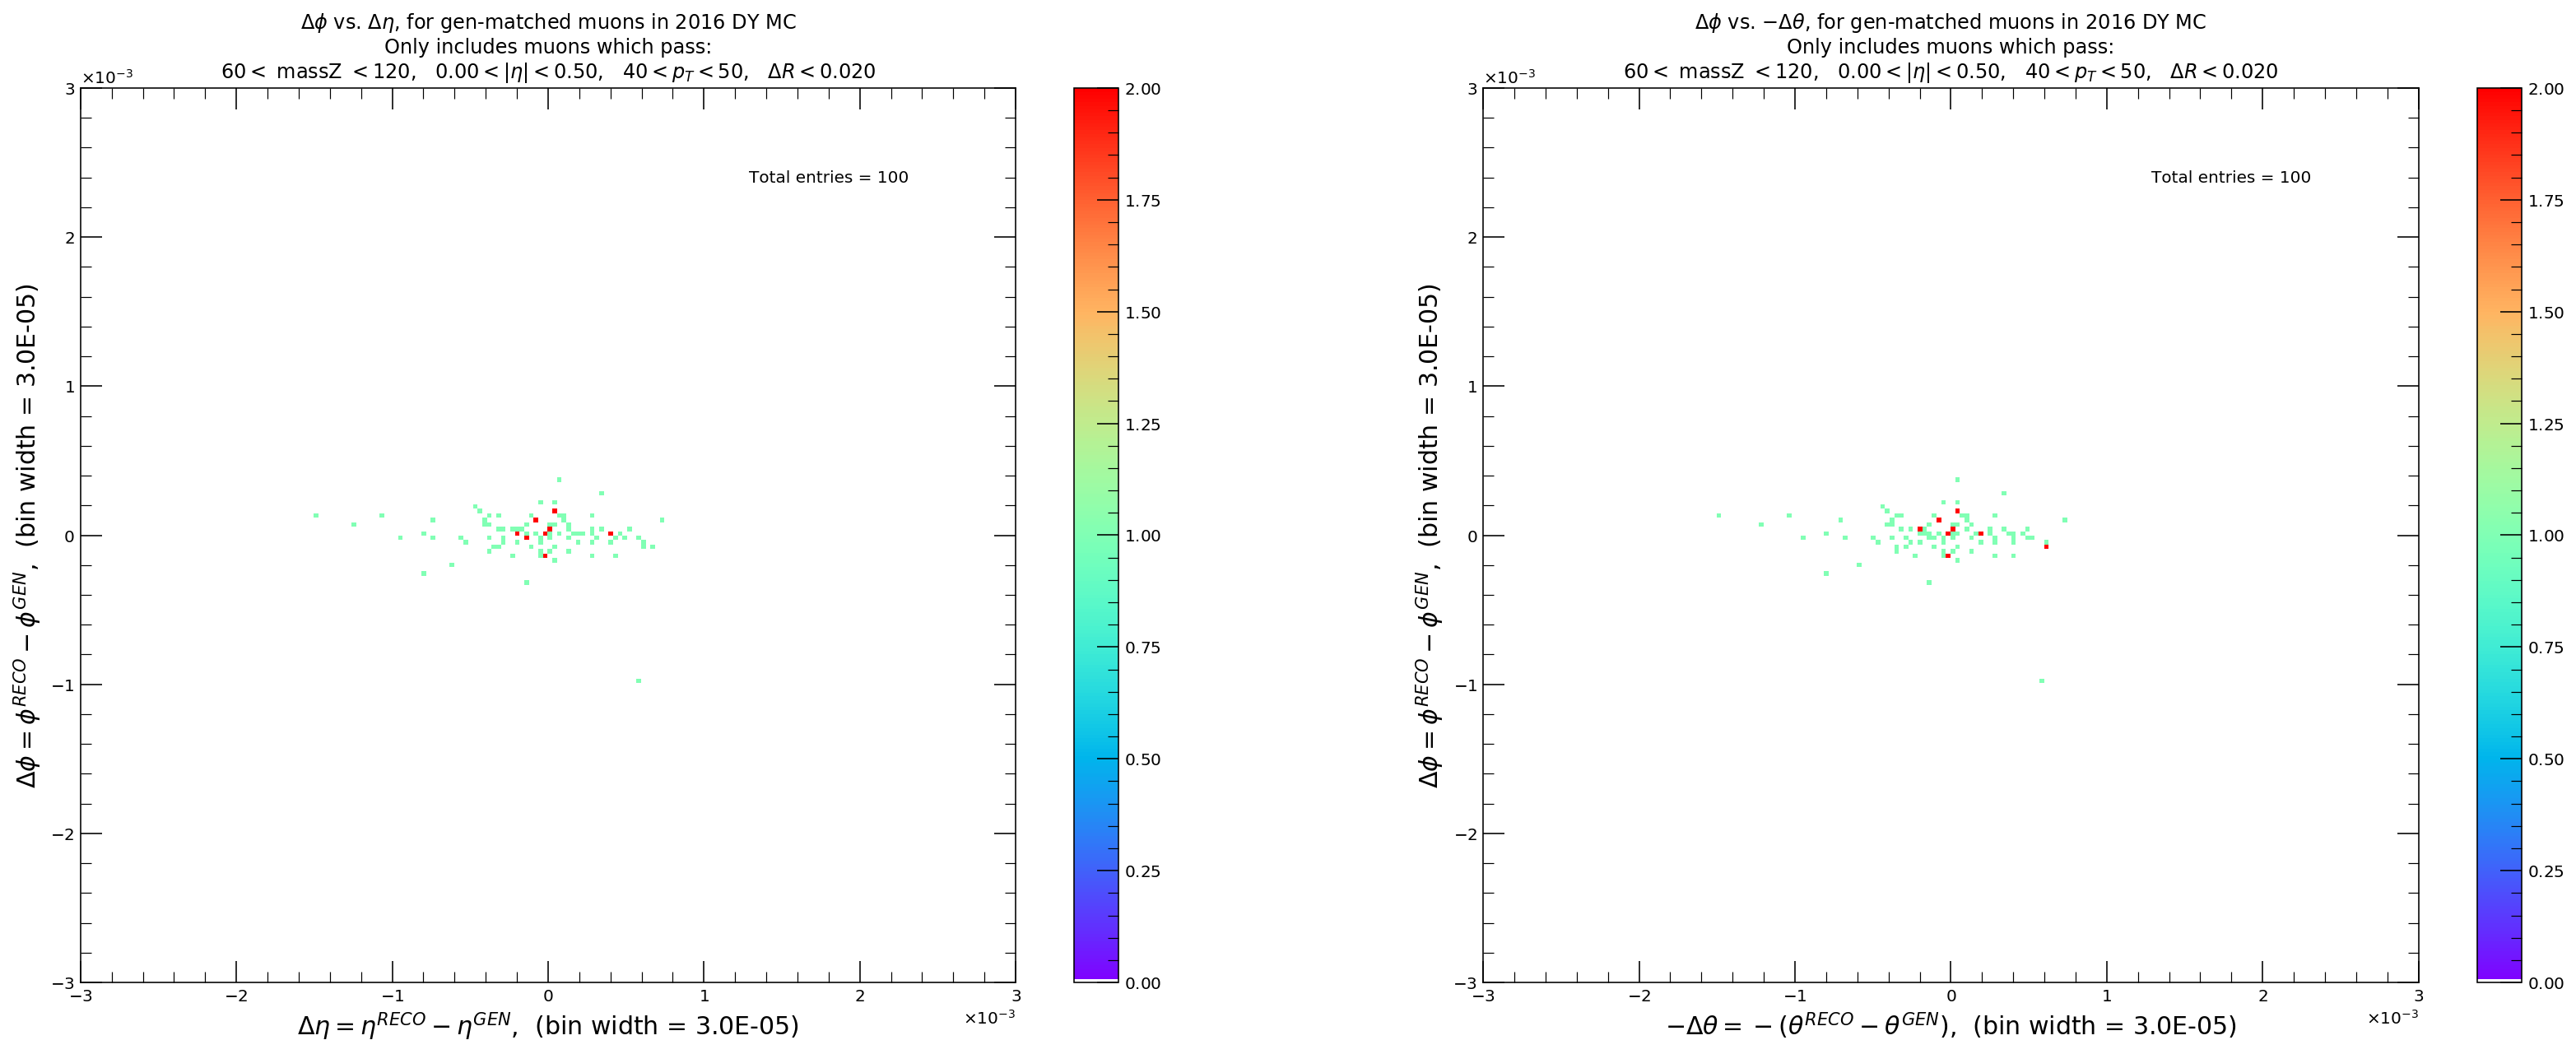

In [4]:
%%time
%config InlineBackend.figure_format ='retina'

kbin = KinemBinnedEtaPt(df_MC_2016, n_evts=5000, eta_cut_ls=[0.00, 0.50], pT_cut_ls=[40, 50], dR_cut=0.02)

kbin.make2Dplot_dPhi_vs_dEtaANDdTheta(run_over_only_n_evts=100,
                                        x1_bounds=[-0.003, 0.003, 0.00003], 
                                        x2_bounds=[-0.003, 0.003, 0.00003], 
                                        y_bounds=[-0.003, 0.003, 0.00003], 
                                        exclusive=True,
                                        save_plot=True, 
                                        save_as_png=False,
                                        verbose=True,
                                        outpath="/Users/Jake/Desktop/20200410/2Dplots_dphi_vs_deta__onlyselectedmuons_pcuts_DELTEMEPLZ/"
                                        )

### $\Delta \phi$ vs. $\Delta \eta$ 2D plots.

In [ ]:
%%time
%config InlineBackend.figure_format ='retina'

kbin_0eta2p4_40pT60 = KinemBinnedEtaPt(df_MC_2016, n_evts=10000, eta_cut_ls=[0, 0.8], pT_cut_ls=[40, 60], dR_cut=0.002)
# kbin_0eta2p4_40pT60.make2Dplot_pT_vs_eta(eta_2D_limits=[-2.5, 2.5, 0.1], pT_2D_limits=[0, 100, 1], save_plot=False, outpath="/Users/Jake/Desktop/20200403/")
kbin_0eta2p4_40pT60.make2Dplot_dphivsdeta(x_2D_limits=[-0.005, 0.005, 0.00005], y_2D_limits=[-0.0025, 0.0025, 0.00005], save_plot=False, outpath="/Users/Jake/Desktop/20200403/2Dplots_dphi_vs_deta/")

### Loop over $p_{T}$ vs. $\eta$ plots

In [ ]:
n_evts = 100000
eta_bin_edges = [0.0, 0.9, 1.4, 2.4] 
# eta_bin_edges = [0.9, 1.4, 2.4] 
# eta_bin_edges = [0.9, 1.4, 2.4] 
pT_bin_edges = [5, 20, 30, 40, 50, 60, 100]
# pT_bin_edges = [30, 40, 50]
# pT_bin_edges = [40, 50]
eta_2D_limits = [-2.5, 2.5, 0.1] 
pT_2D_limits = [0, 100, 1] 
save_plot = True 
outpath = "/Users/Jake/Desktop/20200403/2Dplots_pT_vs_eta_1E5evts/"
                            
for k in range(len(eta_bin_edges)-1):
    this_eta = eta_bin_edges[k]
    next_eta = eta_bin_edges[k+1]

    for m in range(len(pT_bin_edges)-1):
        this_pT = pT_bin_edges[m]
        next_pT = pT_bin_edges[m+1]

        df_kinembinned = KinemBinnedDataFrame(df_MC_2016, n_evts=n_evts, eta_cut_ls=[this_eta, next_eta], pT_cut_ls=[this_pT, next_pT], dR_cut=0.002)
        df_kinembinned.make2Dplot_pT_vs_eta(eta_2D_limits=eta_2D_limits, pT_2D_limits=pT_2D_limits, save_plot=True, outpath=outpath)

# Make a PDF of 1 kinematic bin: all the distributions!

In [17]:
%%time
# %%capture

n_evts_scan = 10000000
n_evts_keep = 5000

# eta_bin_edges = [0.00, 0.30] # barrel
# eta_bin_edges = [0.80, 1.10]  # overlap
eta_bin_edges = [2.10, 2.40]  # endcap

# eta_bin_edges = [0.00, 0.10, 0.20, 0.30]    # barrel
# eta_bin_edges = [0.70, 0.80, 0.90, 1.00, 1.10, 1.20]    # overlap
# eta_bin_edges = [2.00, 2.10, 2.20, 2.30, 2.40]    # endcap

#--- Could be either pT or p. User specifies when initializing kbin. ---#
# p_bin_edges = [5, 20, 30, 40, 50, 60, 100]
# p_bin_edges = [5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
# p_bin_edges = [5, 7, 10, 15, 20]
p_bin_edges = [20, 40, 60, 80, 100]
use_ptotal_instead = False  # p_total or pT

outpath = "/Users/Jake/Desktop/20200410/2Dplots_dPhivsdEtaANDdTheta/"
pdf_name_base = "combinedpdf_endcap_highpT"

save_plot = False  # Save individual plots.
save_as_png = False
save_pdf = True  
verbose = True

if (save_plot) and (save_pdf or save_as_png):
    err_msg = "PROGRAM STOPPED: both 'save_plot' and 'save_pdf' are True. Make one of them False."
    raise RuntimeError(err_msg)

makeDirs(outpath)
all_kbin_ls = []
for k in range(len(eta_bin_edges)-1):
    this_eta = eta_bin_edges[k]
    next_eta = eta_bin_edges[k+1]
    
    kbin_ls = []
    for m in range(len(p_bin_edges)-1):
        this_p = p_bin_edges[m]
        next_p = p_bin_edges[m+1]

        kbin = KinemBinnedEtaPt(df_MC_2016, 
                                n_evts=n_evts_scan, 
                                eta_cut_ls=[this_eta, next_eta], 
                                pT_cut_ls=[this_p, next_p], 
                                use_ptotal_instead=False, 
                                dR_cut=0.02, verbose=verbose)
        kbin_ls.append(kbin)
        
    # Finished looping over p bins.
    evts_max = n_evts_keep

    if save_pdf and not save_plot:
        # Save plots into one PDF:
        pT_min = min( [kb.pT_min for kb in kbin_ls] )
        pT_max = max( [kb.pT_max for kb in kbin_ls] )
        n_plots = len(kbin_ls)

        title_str_pT_min = f"{pT_min}" if pT_min < 10 else f"{pT_min}"  # For plot-ordering purposes.
        pdf_name = pdf_name_base + f"__{this_eta}_eta_{next_eta}"# + f"__{title_str_pT_min}_pT_{pT_max}"
        pdf_name += f"__{pT_min}_pT_{pT_max}"# + f"__{title_str_pT_min}_pT_{pT_max}"
        pdf_name += f"__{n_plots}plots"
        pdf_name = make_str_title_friendly(pdf_name) + ".pdf"

        outfile = os.path.join(outpath, pdf_name)

        with PdfPages(outfile) as pdf:
            for kbinned in kbin_ls:
                kbinned.make2Dplot_dPhi_vs_dEtaANDdTheta(run_over_only_n_evts=evts_max,
                                                           x1_bounds=[-0.003, 0.003, 0.00003], 
                                                           x2_bounds=[-0.003, 0.003, 0.00003], 
                                                           y_bounds=[-0.003, 0.003, 0.00003], 
                                                           exclusive=True,
                                                           save_plot=save_plot, 
                                                           save_as_png=save_as_png,
                                                           verbose=verbose,
                                                           outpath=outpath
                                                           )
                
# HERE!                kbinned.MAKEOTHERDISTRIBUTIONS!

                pdf.savefig()  # saves the current figure into a pdf page
                plt.close()

        print("[INFO] PDF created at", outfile, "\n")

        all_kbin_ls.append(kbin_ls)

        plt.close('all')
        
    elif save_plot and not save_pdf:
        # Save individual plots:
        for kbinned in kbin_ls:
            kbinned.make2Dplot_dPhi_vs_dEtaANDdTheta(run_over_only_n_evts=evts_max,
                                                       x1_bounds=[-0.003, 0.003, 0.00003], 
                                                       x2_bounds=[-0.003, 0.003, 0.00003], 
                                                       y_bounds=[-0.003, 0.003, 0.00003], 
                                                       exclusive=True,
                                                       save_plot=save_plot, 
                                                       save_as_png=save_as_png,
                                                       verbose=verbose,
                                                       outpath=outpath
                                                       )
            plt.close('all')

Events found: 728252 (7.28% of total events), using cuts: $60 <$ massZ $< 120$,   $2.10 < \left| \eta \right| < 2.40$,   $20 < p_{T} < 40$,   $\Delta R < 0.020$
Events found: 533172 (5.33% of total events), using cuts: $60 <$ massZ $< 120$,   $2.10 < \left| \eta \right| < 2.40$,   $40 < p_{T} < 60$,   $\Delta R < 0.020$
Events found: 94705 (0.95% of total events), using cuts: $60 <$ massZ $< 120$,   $2.10 < \left| \eta \right| < 2.40$,   $60 < p_{T} < 80$,   $\Delta R < 0.020$
Events found: 27814 (0.28% of total events), using cuts: $60 <$ massZ $< 120$,   $2.10 < \left| \eta \right| < 2.40$,   $80 < p_{T} < 100$,   $\Delta R < 0.020$
[INFO] PDF created at /Users/Jake/Desktop/20200410/2Dplots_dPhivsdEtaANDdTheta/combinedpdf_endcap_highpT__2p1_eta_2p4__20_pT_100__4plots.pdf 

CPU times: user 2min 27s, sys: 3min 30s, total: 5min 58s
Wall time: 8min 33s
